# Introduction to JPEG: Practical tools

Martin Beneš

<div style="text-align: center">
<img src="https://www.uibk.ac.at/media/filer_public/00/c3/00c369ba-9e7a-42a4-9f73-466c81dc951a/universitaet-innsbruck-logo-cmyk-farbe.jpg" style="height: 5em; display: inline; padding-right: 2em" />
<img src="https://www.uncoverproject.eu/wp-content/uploads/2021/05/UNCOVER-Logog-440x92.5-final-1.0.png" style="height: 4em; display: inline; padding-left: 2em" />
</div>

## Notebook setup

For this notebook, we will use a sample image `00001.tif` from ALASKA database. Run following code chunk to download it.

In [1]:
# download 00001.tif from ALASKA website
import requests
res = requests.get('http://alaska.utt.fr/DATASETS/ALASKA_v2_TIFF_512_COLOR/00001.tif', verify=False)
with open('00001.tif', 'wb') as f:
    f.write(res.content)

/opt/miniconda3/envs/dev/lib/python3.8/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'alaska.utt.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


## PNG is lossless

We load the image `00001.tif` that will be used in this exercise using Python imaging library `PIL`.

The PIL object representing the image is converted to a `numpy` array of pixels.

In [2]:
import numpy as np
from PIL import Image
im = Image.open('00001.tif')  # load image
RGB = np.array(im)  # PIL to numpy

We can look at the shape of the image. The image consists of $512 \times 512$ pixels, each of which has has $3$ color values (R, G, B).

In [3]:
RGB.shape

(512, 512, 3)

We look at the image by using package `matplotlib`.

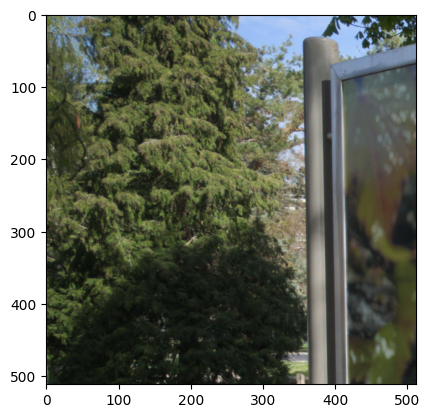

In [4]:
import matplotlib.pyplot as plt
plt.imshow(RGB);

To demostrate that PNG compression is lossless, we compress and decompress the image.

In [5]:
im_out = Image.fromarray(RGB)  # numpy to PIL
im_out.save('output.png')  # compress to PNG

In [6]:
im_in = Image.open('output.png')  # decompress PNG
rgb_png = np.array(im_in)  # PIL to numpy

Lossless compression does not change the image data. For PNG, the original and the recompressed image are the same.

In [7]:
(RGB == rgb_png).all()  # identical

True

## JPEG is lossy

Let us do the same with JPEG compression, i.e., compress and decompress the image.

In [8]:
im_out = Image.fromarray(RGB)  # numpy to PIL
im_out.save('output.jpeg')  # compress to JPEG

In [9]:
im_in = Image.open('output.jpeg')  # decompress JPEG
rgb_jpeg = np.array(im_in)  # PIL to numpy

The JPEG-compressed image differs from the original. JPEG compression changes the image.

In [10]:
(RGB == rgb_jpeg).all()  # images differ

False

We can compute the difference image (the difference between the images) and visualize to see the magnitude of changes.

For context, steganography usually makes changes $\pm1$.

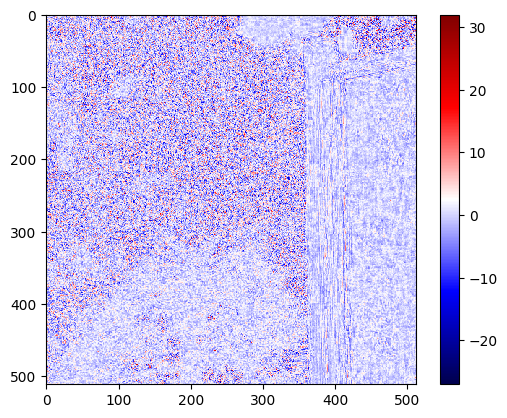

In [11]:
diff_G = RGB[:, :, 1] - rgb_jpeg[:, :, 1].astype('int')  # diff. image
plt.imshow(diff_G, cmap='seismic', interpolation='nearest')  # heatmap
plt.colorbar();

## Trading off file size and image quality via the QF

The primary goal of JPEG compression is to reduce the file size while maintaining high image quality. The most influential parameter of JPEG compression is the quality factor (QF). Many popular JPEG implementations use quality factors between $0$ and $100$.

To have fine-grained control over JPEG compression parameters, we will use the Python package `jpeglib`.

In [12]:
!pip install jpeglib

Same as before, we recompress the original image using JPEG compression. Only this time, we specify the QF by setting the `qt` parameter of the `write_spatial` method.

In [13]:
import jpeglib

In [14]:
im_out = jpeglib.from_spatial(RGB)  # numpy to jpeglib
im_out.write_spatial('output_QF100.jpeg', qt=100)  # compress

In [15]:
im_in = jpeglib.read_spatial('output_QF100.jpeg')  # decompress
rgb_jpeg_qf100 = im_in.spatial  # jpeglib to numpy

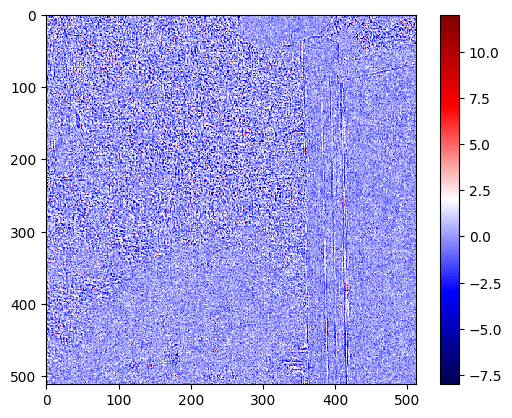

In [16]:
diff_G = RGB[:, :, 1] - rgb_jpeg_qf100[:, :, 1].astype('int')
plt.imshow(diff_G, cmap='seismic', interpolation='nearest')  # heatmap
plt.colorbar();

## Hands-on: Visual analysis

- What visual artifacts does JPEG compression leave? (hint: zoom in)
- What impact does the quality factor have?

<div style="text-align: center">
<img src="https://github.com/uibk-uncover/prague-jpeg-demo/blob/main/img/1_jpeg_qf.png?raw=true" style="height: 15em"/>
</div>

### Solution

The artifacts of JPEG are visible if you zoom in.

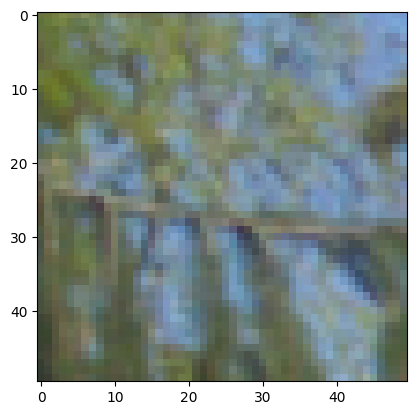

In [17]:
plt.imshow(RGB[:50, :50]);

For QF75, we might notice some block structure. The reason is that JPEG compression splits the image into non-overlapping $8 \times 8$ blocks.

In [18]:
# recompress JPEG (with QF75)
jpeglib.from_spatial(RGB).write_spatial('output_jpeg_qf75.jpeg', qt=75)
rgb_jpeg_qf75 = jpeglib.read_spatial('output_jpeg_qf75.jpeg').spatial

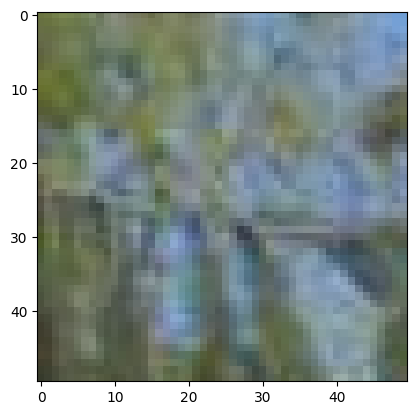

In [19]:
plt.imshow(rgb_jpeg_qf75[:50, :50]);

With QF25, the block structure becomes very visible.

As JPEG removes high frequencies, we can see that content of each individual block is becoming flat, while continuity between adjacent blocks is destroyed by stronger compression.

In [20]:
# recompress JPEG (with QF25)
jpeglib.from_spatial(RGB).write_spatial('output_jpeg_qf25.jpeg', qt=25)
rgb_jpeg_qf25 = jpeglib.read_spatial('output_jpeg_qf25.jpeg').spatial

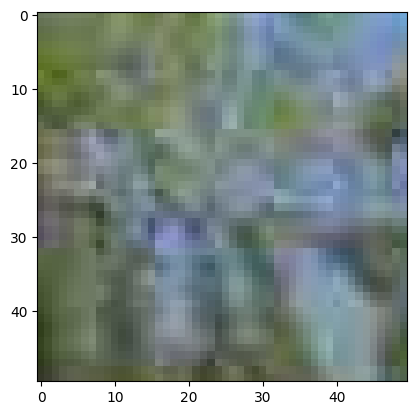

In [21]:
plt.imshow(rgb_jpeg_qf25[:50, :50]);